In [112]:
import pandas as pd
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

In [113]:
#Preprocecing
#First of all we will check how many null values there are in each column
df = pd.read_csv('shorterChessDf.csv')

df_first_lines = df.head(500000)
df_first_lines.to_csv('shorterChessDf.csv', index=False)
df_first_lines.tail(10)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
49990,Blitz,andy1234,mehdiebrahimian,1-0,2016.07.01,06:36:49,1916,1893,10.0,-9.0,B21,"Sicilian Defense: Smith-Morra Gambit Accepted,...",180+0,Normal,1. e4 c5 2. d4 cxd4 3. c3 dxc3 4. Nxc3 e6 5. N...
49991,Classical,Mazwellw,dfreshness,0-1,2016.07.01,06:36:50,1479,1503,-10.0,11.0,A46,Yusupov-Rubinstein System,480+0,Normal,1. d4 Nf6 2. e3 e6 3. Nf3 Be7 4. c4 c5 5. Nc3 ...
49992,Blitz,velebog,olee,1-0,2016.07.01,06:36:50,1724,1632,8.0,-7.0,C00,French Defense: La Bourdonnais Variation,300+0,Normal,1. e4 e6 2. f4 d6 3. Nf3 c6 4. d4 Ne7 5. c4 f6...
49993,Blitz,essazarei1,Ali08,0-1,2016.07.01,06:36:51,1642,1700,-9.0,9.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,300+0,Normal,1. e4 d5 2. exd5 Qxd5 3. Nc3 Qd8 4. Nf3 Bg4 5....
49994,Blitz,mosafer,ebi2016,1-0,2016.07.01,06:36:51,2105,2056,11.0,-9.0,D55,"Queen's Gambit Declined: Modern Variation, Nor...",180+0,Normal,1. d4 d5 2. c4 e6 3. Nc3 Nf6 4. Bg5 Be7 5. Nf3...
49995,Blitz,nassar,ZB_CVillamil,0-1,2016.07.01,06:36:54,1502,1615,-11.0,7.0,C00,French Defense #2,300+4,Normal,1. e4 e6 2. Bc4 d5 3. exd5 exd5 4. Bb5+ c6 5. ...
49996,Classical,ivangrad,Nonpareil,0-1,2016.07.01,06:36:53,2160,2588,-2.0,2.0,A40,Queen's Pawn,120+9,Normal,1. d4 f6 2. c3 d5 3. Bf4 Nc6 4. Nf3 g5 5. Bg3 ...
49997,Bullet,tebib,TheTirelessQuoter,0-1,2016.07.01,06:36:44,1793,1924,-7.0,7.0,C00,French Defense: Queen's Knight,60+0,Time forfeit,1. e4 { [%eval 0.18] } 1... e6 { [%eval 0.22] ...
49998,Classical,EdeTede,stevecipriani,1-0,2016.07.01,06:36:56,1580,1492,9.0,-8.0,D06,Queen's Gambit Refused: Marshall Defense,180+10,Normal,1. d4 d5 2. c4 Nf6 3. Nf3 e6 4. e3 Bd6 5. c5 B...
49999,Bullet,Benjibubu,MacTep_LLlaxMaT,1-0,2016.07.01,06:37:00,1879,1342,1.0,-2.0,C40,Latvian Gambit Accepted,60+2,Normal,1. e4 e5 2. Nf3 f5 3. exf5 d6 4. Nc3 Bxf5 5. B...


In [114]:
# Create a boolean DataFrame where True indicates 'eval' appears in that cell
contains_eval = df.applymap(lambda x: 'eval' in str(x))

# Use any(axis=1) to check if 'eval' appears in any column for each row
rows_with_eval = contains_eval.any(axis=1)
# Filter the DataFrame to get only the rows that contain 'eval'
filtered_df = df[rows_with_eval]

# Display the filtered DataFrame
filtered_df.tail(10)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
49943,Bullet,notacheater,Liakoni,1-0,2016.07.01,06:36:06,2032,1918,8.0,-8.0,D78,"Neo-Gruenfeld Defense: Classical Variation, Mo...",60+0,Time forfeit,1. Nf3 { [%eval 0.15] } 1... Nf6 { [%eval 0.17...
49952,Bullet,Brocadox,WeSpaceNow,1-0,2016.07.01,06:36:15,1662,1388,5.0,-51.0,C40,King's Pawn Game: Damiano Defense,60+1,Time forfeit,1. e4 { [%eval 0.24] } 1... e5 { [%eval 0.22] ...
49959,Classical,Vituspix,BravestIIX,1-0,2016.07.01,06:36:20,2275,2227,13.0,-9.0,B88,"Sicilian Defense: Sozin Attack, Leonhardt Vari...",300+5,Normal,1. e4 { [%eval 0.31] } 1... c5 { [%eval 0.31] ...
49960,Blitz,semitco877,zoran62,0-1,2016.07.01,06:36:10,1817,1802,-11.0,12.0,D08,Queen's Gambit Refused: Albin Countergambit,360+1,Normal,1. d4 { [%eval 0.24] } 1... d5 { [%eval 0.15] ...
49967,Classical,Kasy87,stas1995stas,1-0,2016.07.01,06:36:26,1838,1553,4.0,-4.0,C55,Italian Game: Anti-Fried Liver Defense,900+10,Normal,1. e4 { [%eval 0.15] } 1... e5 { [%eval 0.15] ...
49968,Classical,EniotnaTuaneh11,kalenkin_av,0-1,2016.07.01,06:36:27,1478,1508,-79.0,67.0,C20,King's Pawn Game: Macleod Attack,3600+5,Time forfeit,1. e4 { [%eval 0.19] } 1... e5 { [%eval 0.24] ...
49975,Correspondence,end1dream,belgiancrusader,1/2-1/2,2016.07.01,06:36:33,1500,1587,53.0,-4.0,E20,Nimzo-Indian Defense: Ragozin Variation,-,Normal,1. d4 { [%eval 0.17] } 1... d5 { [%eval 0.13] ...
49986,Bullet tournament,viterbese,mch21,0-1,2016.07.01,06:36:39,2007,2241,-5.0,7.0,C50,Italian Game,60+0,Normal,1. e4 { [%eval 0.22] } 1... Nc6 { [%eval 0.45]...
49987,Classical,Modnar,parviz1340,0-1,2016.07.01,06:36:38,2031,2020,-11.0,12.0,A21,"English Opening: King's English Variation, Rev...",720+3,Time forfeit,1. c4 { [%eval 0.15] } 1... e5 { [%eval 0.07] ...
49997,Bullet,tebib,TheTirelessQuoter,0-1,2016.07.01,06:36:44,1793,1924,-7.0,7.0,C00,French Defense: Queen's Knight,60+0,Time forfeit,1. e4 { [%eval 0.18] } 1... e6 { [%eval 0.22] ...


In [115]:
filtered_df['AN']

56       1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...
57       1. e4 { [%eval 0.31] } 1... c5 { [%eval 0.37] ...
58       1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...
69       1. e4 { [%eval 0.22] } 1... e5 { [%eval 0.25] ...
81       1. d4 { [%eval 0.24] } 1... d5 { [%eval 0.14] ...
                               ...                        
49968    1. e4 { [%eval 0.19] } 1... e5 { [%eval 0.24] ...
49975    1. d4 { [%eval 0.17] } 1... d5 { [%eval 0.13] ...
49986    1. e4 { [%eval 0.22] } 1... Nc6 { [%eval 0.45]...
49987    1. c4 { [%eval 0.15] } 1... e5 { [%eval 0.07] ...
49997    1. e4 { [%eval 0.18] } 1... e6 { [%eval 0.22] ...
Name: AN, Length: 6439, dtype: object

In [116]:
# Filter the DataFrame to remove rows that contain 'eval'
df_without_eval = df[~rows_with_eval]


In [117]:
df_without_eval

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016.06.30,22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016.06.30,22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Correspondence,Jvayne,Wsjvayne,1-0,2016.06.30,22:00:02,1706,1317,27.0,-25.0,A00,Van't Kruijs Opening,-,Normal,1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4,Blitz tournament,kyoday,BrettDale,0-1,2016.06.30,22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,Blitz,mosafer,ebi2016,1-0,2016.07.01,06:36:51,2105,2056,11.0,-9.0,D55,"Queen's Gambit Declined: Modern Variation, Nor...",180+0,Normal,1. d4 d5 2. c4 e6 3. Nc3 Nf6 4. Bg5 Be7 5. Nf3...
49995,Blitz,nassar,ZB_CVillamil,0-1,2016.07.01,06:36:54,1502,1615,-11.0,7.0,C00,French Defense #2,300+4,Normal,1. e4 e6 2. Bc4 d5 3. exd5 exd5 4. Bb5+ c6 5. ...
49996,Classical,ivangrad,Nonpareil,0-1,2016.07.01,06:36:53,2160,2588,-2.0,2.0,A40,Queen's Pawn,120+9,Normal,1. d4 f6 2. c3 d5 3. Bf4 Nc6 4. Nf3 g5 5. Bg3 ...
49998,Classical,EdeTede,stevecipriani,1-0,2016.07.01,06:36:56,1580,1492,9.0,-8.0,D06,Queen's Gambit Refused: Marshall Defense,180+10,Normal,1. d4 d5 2. c4 Nf6 3. Nf3 e6 4. e3 Bd6 5. c5 B...


In [83]:
df_first_lines['AN']

0        1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1        1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2        1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3        1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4        1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
                               ...                        
49995    1. e4 e6 2. Bc4 d5 3. exd5 exd5 4. Bb5+ c6 5. ...
49996    1. d4 f6 2. c3 d5 3. Bf4 Nc6 4. Nf3 g5 5. Bg3 ...
49997    1. e4 { [%eval 0.18] } 1... e6 { [%eval 0.22] ...
49998    1. d4 d5 2. c4 Nf6 3. Nf3 e6 4. e3 Bd6 5. c5 B...
49999    1. e4 e5 2. Nf3 f5 3. exf5 d6 4. Nc3 Bxf5 5. B...
Name: AN, Length: 50000, dtype: object

In [119]:
# Create a boolean DataFrame where True indicates 'eval' appears in that cell
contains_bracelet = df_without_eval.applymap(lambda x: '{' in str(x))

# Use any(axis=1) to check if 'eval' appears in any column for each row
rows_with_bracelet = contains_bracelet.any(axis=1)
# Filter the DataFrame to get only the rows that contain 'eval'
filtered_df = df_without_eval[rows_with_bracelet]

# Display the filtered DataFrame
filtered_df.tail(10)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN


There are no more eval values or {} signs on the df.

In [120]:
# Define the function to split chess moves
def split_chess_moves(moves, turns):
    move_list = moves.split()
    separated_moves = []
    turn_number = 1
    for i in range(0, len(move_list), 3):
        if turn_number > turns:
            break
        separated_moves.append(move_list[i + 1] if i + 1 < len(move_list) else "")
        separated_moves.append(move_list[i + 2] if i + 2 < len(move_list) else "")
        turn_number += 1
    return separated_moves

In [87]:
# import pandas as pd
# 
# # Create a sample DataFrame
# data = {
#     'Event': ['Event1', 'Event2'],
#     'White': ['PlayerA', 'PlayerB'],
#     'Black': ['PlayerC', 'PlayerD'],
#     'Result': ['1-0', '0-1'],
#     'AN': [
#         '1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e4 6. Ne5 cxd5 7. Qa4+ Bd7 8. Rfd1 1-0' ,
#         '1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 g6 6. Nbd2 Bg7 7. g3 Be6 8. Kh1 Bh3# 0-1'
#     ]
# }
# 
# df = pd.DataFrame(data)
# 
# # Function to determine the result (dummy function for this example)
# def determine_result(result):
#     return result  # Replace with actual logic
# 
# # Apply the determine_result function
# df['Result'] = df['Result'].apply(lambda x: determine_result(x))
# 
# number_of_turns = 3  # Specify the number of turns we want to extract
# 
# # Define the function to split chess moves
# def split_chess_moves(moves, turns):
#     move_list = moves.split(',')
#     separated_moves = []
#     turn_number = 1
#     for i in range(0, len(move_list), 2):
#         if turn_number > turns:
#             break
#         separated_moves.append(move_list[i] if i < len(move_list) else "")
#         separated_moves.append(move_list[i + 1] if i + 1 < len(move_list) else "")
#         turn_number += 1
#     
#     # If fewer than the required number of moves, fill with empty strings
#     while len(separated_moves) < 2 * turns:
#         separated_moves.append("")
#     
#     return separated_moves
# 
# # Create new columns for the specified number of turns
# columns = [f"Turn {i + 1} White" for i in range(number_of_turns)] + [f"Turn {i + 1} Black" for i in range(number_of_turns)]
# 
# # Apply the split_chess_moves function to each row in the DataFrame and expand the list into separate columns
# moves_split = df['AN'].apply(lambda x: pd.Series(split_chess_moves(x, number_of_turns)))
# 
# # Combine the new columns with the original DataFrame
# df[columns] = moves_split
# 
# # Drop specified columns which would not be used in the training
# df.drop(columns=['Event', 'White', 'Black', 'AN'], inplace=True)
# 
# # Display the modified DataFrame
# df.tail(8)

In [121]:
# Unique values in the 'Result' column
unique_names = df['Result'].unique()
print("Unique values in 'Result' column:", unique_names)

Unique values in 'Result' column: ['1-0' '0-1' '1/2-1/2']


In [122]:
def determine_result(result):
    if result == '1-0':
        return 1
    elif result == '0-1':
        return 0
    elif result == '1/2-1/2':
        return 2
    else:
        return -1  # for any unexpected result format

In [123]:
#df = pd.read_csv('shorterChessDf.csv')  # Load the DataFrame

df_without_eval['Result'] = df_without_eval['Result'].apply(lambda x: determine_result(x))  # Apply the determine_result function

number_of_turns = 20  # Specify the number of turns we want to extract

columns = [f"Turn {i + 1} White" for i in range(number_of_turns)] + [f"Turn {i + 1} Black" for i in range(number_of_turns)]  # Create new columns for the specified number of turns
moves_split = df_without_eval['AN'].apply(lambda x: pd.Series(split_chess_moves(x, number_of_turns)))  # Apply the split_chess_moves function to each row in the DataFrame
df_without_eval[columns] = moves_split  # Combine the new columns with the original DataFrame

# Drop specified columns which would not be used in the training
df_without_eval.drop(columns=['Event', 'White', 'Black', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff',
                 'BlackRatingDiff', 'ECO', 'Opening', 'TimeControl', 'Termination', 'AN'], inplace=True)

# Save the modified DataFrame to a CSV file
output_file = 'modified_dataframe.csv'
df_without_eval.to_csv(output_file, index=False)

df_without_eval.head(20)
df_without_eval.tail(10)

C:\Users\yuval\AppData\Local\Temp/ipykernel_23612/1838536399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_eval['Result'] = df_without_eval['Result'].apply(lambda x: determine_result(x))  # Apply the determine_result function
C:\Users\yuval\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\yuval\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Result,Turn 1 White,Turn 2 White,Turn 3 White,Turn 4 White,Turn 5 White,Turn 6 White,Turn 7 White,Turn 8 White,Turn 9 White,...,Turn 11 Black,Turn 12 Black,Turn 13 Black,Turn 14 Black,Turn 15 Black,Turn 16 Black,Turn 17 Black,Turn 18 Black,Turn 19 Black,Turn 20 Black
49989,1,e4,c5,Qe2,d6,Nc3,Nf6,Nf3,Na6,h4,...,Re4,Nc7,Ra1,Bxe4,Ra3,Bf5,Re3,Kf8,b3,Nxh5
49990,1,e4,c5,d4,cxd4,c3,dxc3,Nxc3,e6,Nf3,...,Ne4,Na5,Nd6,Bxd6,Rxc8,Qxc8,exd6,Nxb3,axb3,Qc5
49991,0,d4,Nf6,e3,e6,Nf3,Be7,c4,c5,Nc3,...,Kd1,Rd8,Ra2,Bd7,Qf3,Qd4,Qd3,Ba4+,Nxa4,Qxd3
49992,1,e4,e6,f4,d6,Nf3,c6,d4,Ne7,c4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49993,0,e4,d5,exd5,Qxd5,Nc3,Qd8,Nf3,Bg4,Be2,...,Bxd6,cxd6,O-O-O,Qxh2,Qb4,Rxf2,Qxb7,Rxc2+,Kb1,Rb2+
49994,1,d4,d5,c4,e6,Nc3,Nf6,Bg5,Be7,Nf3,...,Bf4,Nh5,Nxe6,Nxf4,Nxf4,Rxa2,Nxd5,Bd6,Qb3,Ra5
49995,0,e4,e6,Bc4,d5,exd5,exd5,Bb5+,c6,Be2,...,Bg4,Nf6,Bxf6,gxf6,Kh1,f5,Be2,Qe7,Bf1,Qg5
49996,0,d4,f6,c3,d5,Bf4,Nc6,Nf3,g5,Bg3,...,Nb5,Nxg3,fxg3,a6,Na3,Bd6,Qf2,f5,Nc2,Ne7
49998,1,d4,d5,c4,Nf6,Nf3,e6,e3,Bd6,c5,...,O-O,Ne4,Bc1,Qc3,Rb1,Rxa2,Rxb6,Nxf2,Rxf2,Ra1
49999,1,e4,e5,Nf3,f5,exf5,d6,Nc3,Bxf5,Bc4,...,Rxd6,Qc7,Ne4,Bf5,Rd1,Bxe4,Re1,Bd5,Bf4,O-O-O


In [23]:
#We will check for Null values:
# Check for null values
null_counts = df.isnull().sum()
print(null_counts)

Result              0
Turn 1 White        0
Turn 2 White        0
Turn 3 White      162
Turn 4 White      162
Turn 5 White      379
Turn 6 White      379
Turn 7 White      482
Turn 8 White      482
Turn 9 White      604
Turn 10 White     604
Turn 11 White     775
Turn 12 White     775
Turn 13 White     986
Turn 14 White     986
Turn 15 White    1199
Turn 16 White    1199
Turn 17 White    1474
Turn 18 White    1474
Turn 19 White    1806
Turn 20 White    1806
Turn 1 Black     2162
Turn 2 Black     2162
Turn 3 Black     2573
Turn 4 Black     2573
Turn 5 Black     3028
Turn 6 Black     3028
Turn 7 Black     3533
Turn 8 Black     3533
Turn 9 Black     4061
Turn 10 Black    4061
Turn 11 Black    4661
Turn 12 Black    4661
Turn 13 Black    5346
Turn 14 Black    5346
Turn 15 Black    6066
Turn 16 Black    6066
Turn 17 Black    6869
Turn 18 Black    6869
Turn 19 Black    7599
Turn 20 Black    7599
dtype: int64


In [26]:
# Total count of null values in the entire DataFrame
total_nulls = df.isnull().sum().sum()
print(total_nulls)

107530


after splitting the games to  moves, we want to remove all null values because there are 2 options:
1. the game is shorter that the number of turns, and we do not want to consider it (null moves for not existing moves)
2. there are missing moves during the game. i.e. not complete data - we want to remove it.

In [39]:
dfFiltered = df.copy()
dfFiltered = dfFiltered.dropna()
dfFilteredAndCompacted = dfFiltered.head(200000)
dfFiltered.tail(10)

,Result,Turn 1 White,Turn 2 White,Turn 3 White,Turn 4 White,Turn 5 White,Turn 6 White,Turn 7 White,Turn 8 White,Turn 9 White,...,Turn 11 Black,Turn 12 Black,Turn 13 Black,Turn 14 Black,Turn 15 Black,Turn 16 Black,Turn 17 Black,Turn 18 Black,Turn 19 Black,Turn 20 Black
49989,1,e4,c5,Qe2,d6,Nc3,Nf6,Nf3,Na6,h4,...,Re4,Nc7,Ra1,Bxe4,Ra3,Bf5,Re3,Kf8,b3,Nxh5
49990,1,e4,c5,d4,cxd4,c3,dxc3,Nxc3,e6,Nf3,...,Ne4,Na5,Nd6,Bxd6,Rxc8,Qxc8,exd6,Nxb3,axb3,Qc5
49991,0,d4,Nf6,e3,e6,Nf3,Be7,c4,c5,Nc3,...,Kd1,Rd8,Ra2,Bd7,Qf3,Qd4,Qd3,Ba4+,Nxa4,Qxd3
49993,0,e4,d5,exd5,Qxd5,Nc3,Qd8,Nf3,Bg4,Be2,...,Bxd6,cxd6,O-O-O,Qxh2,Qb4,Rxf2,Qxb7,Rxc2+,Kb1,Rb2+
49994,1,d4,d5,c4,e6,Nc3,Nf6,Bg5,Be7,Nf3,...,Bf4,Nh5,Nxe6,Nxf4,Nxf4,Rxa2,Nxd5,Bd6,Qb3,Ra5
49995,0,e4,e6,Bc4,d5,exd5,exd5,Bb5+,c6,Be2,...,Bg4,Nf6,Bxf6,gxf6,Kh1,f5,Be2,Qe7,Bf1,Qg5
49996,0,d4,f6,c3,d5,Bf4,Nc6,Nf3,g5,Bg3,...,Nb5,Nxg3,fxg3,a6,Na3,Bd6,Qf2,f5,Nc2,Ne7
49997,0,e4,{,0.18],},e6,{,0.22],},Nc3,...,-0.32],},Nf3,{,-0.48],},Qb6,{,-0.07],}
49998,1,d4,d5,c4,Nf6,Nf3,e6,e3,Bd6,c5,...,O-O,Ne4,Bc1,Qc3,Rb1,Rxa2,Rxb6,Nxf2,Rxf2,Ra1
49999,1,e4,e5,Nf3,f5,exf5,d6,Nc3,Bxf5,Bc4,...,Rxd6,Qc7,Ne4,Bf5,Rd1,Bxe4,Re1,Bd5,Bf4,O-O-O


In [29]:
rows_with_nulls = dfFilteredAndCompacted[dfFilteredAndCompacted.isnull().any(axis=1)]
rows_with_nulls

,Result,Turn 1 White,Turn 2 White,Turn 3 White,Turn 4 White,Turn 5 White,Turn 6 White,Turn 7 White,Turn 8 White,Turn 9 White,...,Turn 11 Black,Turn 12 Black,Turn 13 Black,Turn 14 Black,Turn 15 Black,Turn 16 Black,Turn 17 Black,Turn 18 Black,Turn 19 Black,Turn 20 Black


Here, we have verified that the data contains no NaNs or Nulls

In [8]:
# Group by these columns and identify groups with more than one entry
duplicate_groups = dfFilteredAndCompacted.groupby(list(dfFilteredAndCompacted.columns[1:])).size()
duplicate_groups = duplicate_groups[duplicate_groups > 1]

# Show the duplicate groups
duplicate_groups

Turn 1 White  Turn 2 White  Turn 3 White  Turn 4 White  Turn 5 White  Turn 6 White  Turn 7 White  Turn 8 White  Turn 9 White  Turn 10 White  Turn 11 White  Turn 12 White  Turn 13 White  Turn 14 White  Turn 15 White  Turn 16 White  Turn 17 White  Turn 18 White  Turn 19 White  Turn 20 White  Turn 1 Black  Turn 2 Black  Turn 3 Black  Turn 4 Black  Turn 5 Black  Turn 6 Black  Turn 7 Black  Turn 8 Black  Turn 9 Black  Turn 10 Black  Turn 11 Black  Turn 12 Black  Turn 13 Black  Turn 14 Black  Turn 15 Black  Turn 16 Black  Turn 17 Black  Turn 18 Black  Turn 19 Black  Turn 20 Black
e4            c5            Nf3           d6            d4            cxd4          Nxd4          Nf6           Nc3           g6             Bc4            Bg7            Be3            O-O            f3             Nc6            Nde2           Bd7            Qd2            Rc8            Bh6           Ne5           Bb3           Nc4           Bxc4          Rxc4          h4            Bxh6          Qxh6          Qa

We are looking for duplicated data. If any duplicates are found (and for different seeds the number may vary), it can be as a result of one of two scenarios: <br>
   1. the whole game is duplicated by chance or by an error in the data (human or otherwise)
   2. The first 20 moves in the two games are coincidentally the same. <br>


Whichever of the cases is correct and as long as the number of duplicates remains very small, it has little to no impact on the results for our purposes, hence are not handled.<br><br>
Since our features are not numeric, and we do not want to limit the data by confiding it to be numeric, linear correlation and various other analysis techniques cannot be performed.

In [31]:
y = dfFilteredAndCompacted['Result']
x = dfFilteredAndCompacted.drop(['Result'], axis=1)

In [38]:
# Step 1: Flatten the DataFrame to a 1D array
all_values = x.values.flatten()

# Step 2: Find the unique values and assign an ID to each
unique_values = pd.unique(all_values)
unique_id_map = {value: idx for idx, value in enumerate(unique_values)}

# Step 3: Replace the original values with their corresponding IDs
df_replaced = x.applymap(lambda i: unique_id_map.get(i) if pd.notnull(i) else None)

print("Original DataFrame:")
print(x)
print("\nDataFrame with unique IDs:")
print(df_replaced)

Original DataFrame:
      Turn 1 White Turn 2 White Turn 3 White Turn 4 White Turn 5 White  \
0               d4           d5           c4           c6           e3   
1               e4           e5           b3          Nf6          Bb2   
2               e4           d5         exd5         Qxd5          Nf3   
3               e3          Nf6          Bc4           d6           e4   
4               e4           c5          Nf3           d6           d4   
...            ...          ...          ...          ...          ...   
49995           e4           e6          Bc4           d5         exd5   
49996           d4           f6           c3           d5          Bf4   
49997           e4            {        0.18]            }           e6   
49998           d4           d5           c4          Nf6          Nf3   
49999           e4           e5          Nf3           f5         exf5   

      Turn 6 White Turn 7 White Turn 8 White Turn 9 White Turn 10 White  ...  \
0          

In [32]:
# Extract all unique moves from the DataFrame
moves = set(x.values.flatten())
moves = {move for move in moves if pd.notnull(move)}

# Create a mapping of moves to numeric values
move_to_num = {move: i for i, move in enumerate(moves)}

# Function to convert moves to numeric values using the mapping
def convert_moves_to_numeric(move):
    return move_to_num.get(move, -1)  # Use -1 for any missing or unknown moves

# Apply the conversion to the DataFrame
x = x.map(convert_moves_to_numeric)

AttributeError: 'DataFrame' object has no attribute 'map'

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [12]:
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train, y_train)
predictionsDummy = dummyModel.predict(X_test)

accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
accuracyDummy

0.48445

<Axes: >

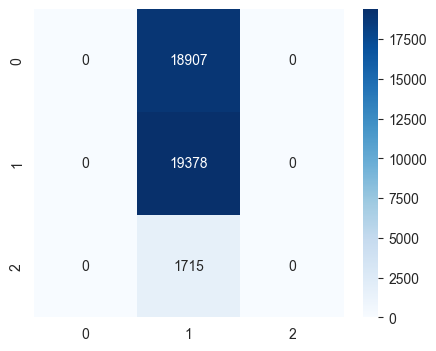

In [19]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')

In [13]:
# Logistic Regression
pipeline = Pipeline([  # Create a pipeline that scales the data and then applies logistic regression
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))  # Handle multi-class
])

pipeline.fit(X_train, y_train)  # Fit the pipeline on the training data
predictionsLogReg = pipeline.predict(X_test)  # Make predictions
accuracyLogReg = accuracy_score(y_test, predictionsLogReg)  # Calculate accuracy
print("Logistic Regression Accuracy:", accuracyLogReg)  # Print the accuracy

Logistic Regression Accuracy: 0.484875


<Axes: >

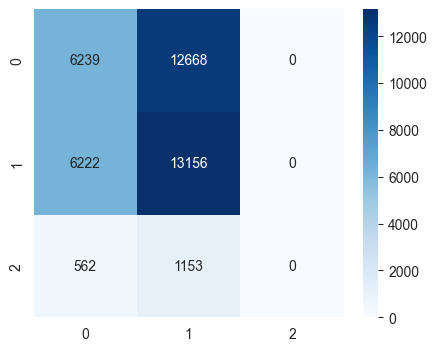

In [20]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')

In [14]:
#AdaBoost
start_timeAdaBoost = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 1000, random_state = 0, learning_rate = 1)
modelAdaBoost.fit(X_train, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achieve result: %s seconds" % timeAdaBoost)

C:\Users\appel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy (AdaBoost):  0.515125
Time taken to achieve result: 632.0828969478607 seconds


<Axes: >

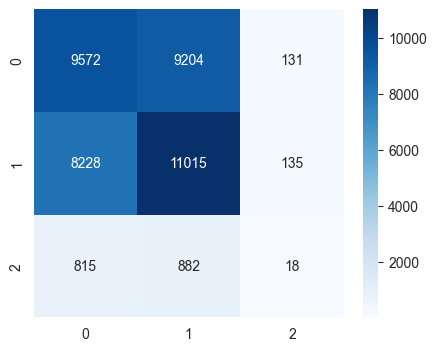

In [21]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')

In [15]:
from sklearn.ensemble import RandomForestClassifier

#Random Forests
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 0)
modelRandForests.fit(X_train, y_train)
predictionsRandForests = modelRandForests.predict(X_test)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achieve result: %s seconds" % (timeRandForests))

Accuracy (Random Forests):  0.5104
Time taken to achieve result: 161.13950371742249 seconds


<Axes: >

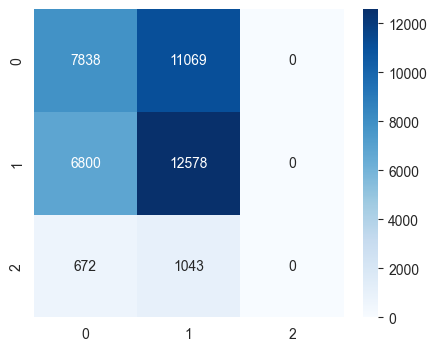

In [22]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')

In [16]:
#XGBoost
start_timeXGBoost = time.time()
warnings.filterwarnings('ignore')
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 2000, verbosity = 0, use_label_encoder = False, n_jobs = -1)
modelXGBoost.fit(X_train, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achieve result: %s seconds" % timeXGBoost)

Accuracy (XGBoost):  0.524175
Time taken to achieve result: 61.23564529418945 seconds


<Axes: >

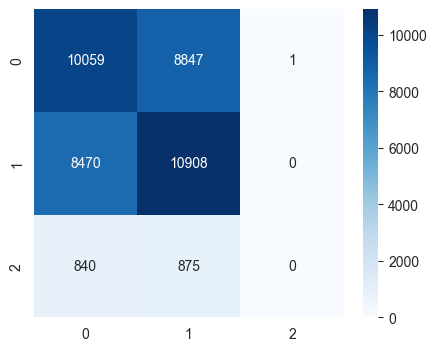

In [23]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

In [33]:


start_timeMLP = time.time()
pipeline = Pipeline([  # Create a pipeline that scales the data and then applies logistic regression
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(500,300,100,3), max_iter=500, alpha=0.3, solver='adam', verbose=10, random_state=0, tol=0.000000001))
])

pipeline.fit(X_train, y_train)
mlpPredictions = pipeline.predict(X_test)
accuracyMLP = metrics.accuracy_score(y_test, mlpPredictions)
print("Accuracy (MLP): ", accuracyMLP)
timeMLP = time.time() - start_timeMLP
print("Time taken to achieve result: %s seconds" % timeMLP)

Iteration 1, loss = 0.93968036
Iteration 2, loss = 0.84596029
Iteration 3, loss = 0.84200000
Iteration 4, loss = 0.84109995
Iteration 5, loss = 0.84080356
Iteration 6, loss = 0.84048109
Iteration 7, loss = 0.84022246
Iteration 8, loss = 0.84021334
Iteration 9, loss = 0.84000621
Iteration 10, loss = 0.83984362
Iteration 11, loss = 0.83977696
Iteration 12, loss = 0.83978393
Iteration 13, loss = 0.83957892
Iteration 14, loss = 0.83954230
Iteration 15, loss = 0.83950568
Iteration 16, loss = 0.83944421
Iteration 17, loss = 0.83931093
Iteration 18, loss = 0.83930606
Iteration 19, loss = 0.83933421
Iteration 20, loss = 0.83929804
Iteration 21, loss = 0.83918533
Iteration 22, loss = 0.83919833
Iteration 23, loss = 0.83915535
Iteration 24, loss = 0.83915902
Iteration 25, loss = 0.83910006
Iteration 26, loss = 0.83919989
Iteration 27, loss = 0.83917242
Iteration 28, loss = 0.83916153
Iteration 29, loss = 0.83911829
Iteration 30, loss = 0.83908746
Iteration 31, loss = 0.83911686
Iteration 32, los

<Axes: >

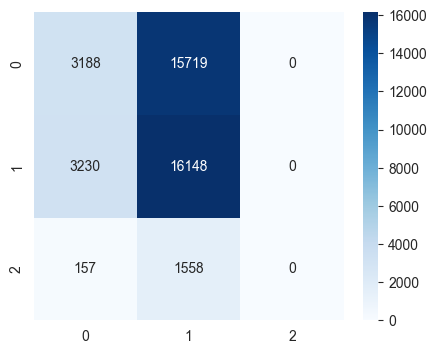

In [34]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, mlpPredictions), cmap = "Blues", annot=True, fmt = '.0f')

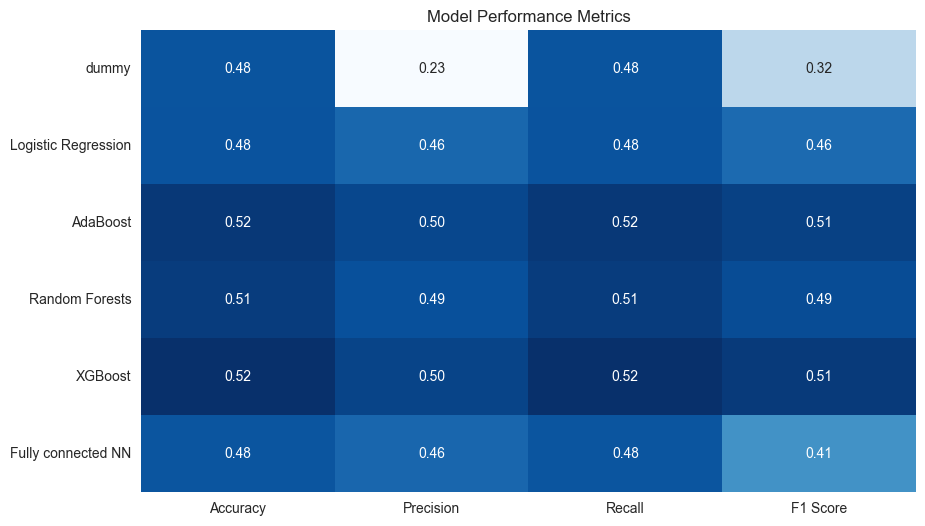

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

results = {}

def createResults(name, predictions, accuracy):
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    results[name] = [accuracy, precision, recall, f1]
    
createResults("dummy", predictionsDummy, accuracyDummy)
createResults("Logistic Regression", predictionsLogReg, accuracyLogReg)
createResults("AdaBoost", predictionsAdaBoost, accuracyAdaBoost)
createResults("Random Forests", predictionsRandForests, accuracyRandForests)
createResults("XGBoost", predictionsXGBoost, accuracyXGBoost)
createResults("Fully connected NN", mlpPredictions, accuracyMLP)

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score']).transpose()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title('Model Performance Metrics')
plt.show()